### Introduction to OpenAI Gym

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gym

import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')


gym.envs.registry

{'ALE/Adventure-v5': EnvSpec(id='ALE/Adventure-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure', version=5),
 'ALE/Adventure-ram-v5': EnvSpec(id='ALE/Adventure-ram-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'ram', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure-ram', version=5),
 'ALE/AirRaid-v5': EnvSpec(id='ALE/AirRaid-v5', 

In [3]:
# GPU training sucks on Mac, as usual
tf.config.set_visible_devices([], 'GPU')

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [5]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [6]:
info

{}

In [7]:
img = env.render()
img.shape

(400, 600, 3)

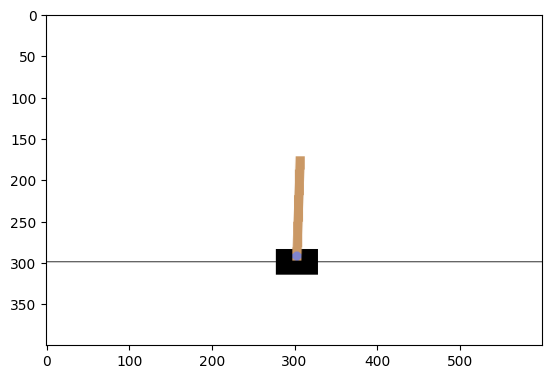

In [8]:
plt.imshow(img)

In [9]:
env.action_space

Discrete(2)

In [10]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [11]:
# Hardcoded policy that accelerates left when the pole is leaning towards the left and
# accelerates right when the pole is leaning toward the right.
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [12]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

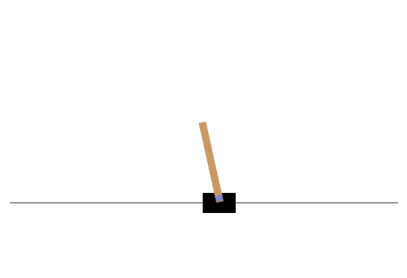

In [13]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [14]:
# extra code – this cell displays an animation of one episode
import matplotlib.animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

### Neural Network Policies

In [15]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

### Policy Gradients

In [16]:
obs, obs[np.newaxis]

(array([ 0.18901952,  0.38444525, -0.22164361, -0.5155623 ], dtype=float32),
 array([[ 0.18901952,  0.38444525, -0.22164361, -0.5155623 ]],
       dtype=float32))

In [17]:
# we pretend that whatever action was chosen was the right one, so
# we can compute a loss and the associated gradients
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis]) # reshape to get the batch dimension
        action = (tf.random.uniform([1, 1])) > left_proba  # False with probability left_proba
        # If action = 0, then y_target (i.e. the target probability of going left) = 1
        # and vice-versa
        y_target = tf.constant([1.]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [18]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [19]:
list(range(50, -1, -1))

[50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0]

In [20]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [21]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [22]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [23]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [24]:
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.01)
# Again, we are pretending that the chosen action was right. So we
# are basically treating the model as a binary classifier
loss_fn = tf.keras.losses.binary_crossentropy

In [25]:
obs, info = env.reset(seed=42)
# Training loop
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)


    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")
          
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 182.8

In [26]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### Markov Decision Processes

In [27]:
# the transition probability of going from s2 to s0
# after playing action a1 is transition_probabilities[2][1][0]
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
# the corresponding reward is rewards[2][1][0]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
# The possible actions in s2 is possible_actions[2]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [28]:
# Initialize Q-values to zero
Q_values = np.full((3, 3), -np.inf)  # -np.info for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [29]:
# Q-value iteration algorithm
gamma = 0.90  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp]
                * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
              for sp in range(3)])
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [30]:
Q_values.argmax(axis=1)  # optimal action for each state

array([0, 0, 1])

### Q-Learning

In [31]:
def step(state, action):
    # In reality we wouldn't know the probabilities or the rewards.
    # We are just using them now to simulate random play
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [32]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [33]:
# extra code – initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [34]:
# Learning rate decays with power scheduling
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90   # discount factor
state = 0  # initial state

for iteration in range(10_000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    # We update the Q_values iteratively, without using the transition probabilities
    # since we don't know what they are (unlike Q-value iteration algorithm)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

### Implementing Deep Q-Learning

In [35]:
# Deep Q-Network for the CartPole environment
# Takes a state as input and outputs one approximate Q-value for each possible action
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [36]:
# select an action, either randomly with probability ε 
# or using the Q-value prediction of the DQN with probability 1 - ε
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [37]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [38]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [39]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [40]:
# Samples a batch of experiences from the replay buffer
# and trains the DQN by performing a single gradient descent step
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [41]:
# Train the model
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")

    if episode > 50:
        training_step(batch_size)

Episode: 600, Steps: 200, eps: 0.010

: 